# Falling Sand Lab Notebook

This notebook documents the full workflow for Tasks 1-4 of the Falling Sand project. Run each code cell in order to load the necessary definitions, instantiate the `SimulationEngine`, capture the metrics, and visualize the heap as it grows.

## Task 1: Model and transition rules

We simulate a rectangular lattice where every cell holds one state from `{EMPTY, FINE, COARSE, WALL}` and the floor is defined by `FloorProfile`. The local neighborhood inspects the three cells directly below a grain (down, down-left, down-right) and applies rules in priority order.

1. Gravity: a particle falls straight down whenever the cell beneath it is `EMPTY`.

2. Diagonal sliding: fine grains always slide diagonally into an available slot, while coarse grains do so only with a 5% probability so steeper heaps form.

3. Lateral fine flow: once sliding stops, fine grains spread horizontally into neighboring empty cells to mimic high flowability.

`delta_h` measures the height difference between the highest and lowest occupied cell, which is the main numeric metric we track. `FloorProfile.SLOPE` and `FloorProfile.STEPPED` define the baseline topography used below.

This high-level description mirrors the rules recorded in `concept.md` sections 5 and 6, keeping the notebook aligned with the documented motivation.


In [47]:
from dataclasses import dataclass
from enum import Enum, IntEnum
from typing import Iterable, List, Optional, Tuple

import math
import numpy as np


class CellState(IntEnum):
    """Represent the available states inside the CA grid."""

    EMPTY = 0
    FINE = 1
    COARSE = 2
    WALL = 3


@dataclass(frozen=True)
class SimulationMetrics:
    """Diagnostics emitted after each snapshot."""

    mix_ratio: float
    delta_h: int
    top_height: int
    bottom_height: int


class FloorProfile(Enum):
    """Predefined terrain shapes used for the static floor."""

    RANDOM = "random"
    FLAT = "flat"
    SLOPE = "slope"
    STEPPED = "stepped"


class SimulationEngine:
    """Encapsulates the cellular automaton that simulates falling sand."""

    def __init__(
        self,
        width: int = 50,
        height: int = 50,
        mix_ratio: float = 1.0,
        coarse_slide: float = 0.05,
        seed: Optional[int] = None,
        floor_profile: FloorProfile = FloorProfile.RANDOM,
        floor_min: int = 2,
        floor_max: Optional[int] = None,
    ) -> None:
        self.width = width
        self.height = height
        self._mix_ratio = self._clamp_ratio(mix_ratio)
        self.coarse_slide = max(0.0, min(1.0, coarse_slide))
        self._rng = np.random.default_rng(seed)
        self.grid = np.full((height, width), CellState.EMPTY, dtype=np.uint8)
        self._floor_profile = floor_profile
        self._floor_min = max(1, floor_min)
        self._floor_max = floor_max
        self._build_floor()

    @staticmethod
    def _clamp_ratio(value: float) -> float:
        return float(max(0.0, min(1.0, value)))

    def _build_floor(self) -> None:
        """Build a floor so particles have a surface to land on."""
        floor_upper = (
            (self._floor_max if self._floor_max is not None else max(2, self.height // 2))
        )
        floor_upper = max(self._floor_min, floor_upper)
        floor_upper = min(self.height - 1, floor_upper)
        floor_min = min(self._floor_min, floor_upper)
        self.grid.fill(CellState.EMPTY)
        heights = self._build_floor_heights(floor_min, floor_upper)
        for column, height in enumerate(heights):
            start_row = self.height - height
            self.grid[start_row:, column] = CellState.WALL

    def _build_floor_heights(self, floor_min: int, floor_max: int) -> np.ndarray:
        """Generate column heights for the requested floor profile."""
        if self._floor_profile == FloorProfile.FLAT or floor_min == floor_max:
            return np.full(self.width, floor_min, dtype=int)

        if self._floor_profile == FloorProfile.SLOPE:
            result = np.linspace(floor_min, floor_max, num=self.width)
            return np.round(result).astype(int)

        if self._floor_profile == FloorProfile.STEPPED:
            steps = max(2, self.width // 6)
            pattern = np.linspace(floor_min, floor_max, num=steps)
            repeats = int(np.ceil(self.width / steps))
            stepped = np.repeat(pattern, repeats)[: self.width]
            return np.round(stepped).astype(int)

        # Random floor
        return self._rng.integers(floor_min, floor_max + 1, size=self.width)

    @property
    def mix_ratio(self) -> float:
        return self._mix_ratio

    @property
    def floor_angle(self) -> float:
        """Return the incline (in degrees) for slope-based floors."""
        if self._floor_profile not in (FloorProfile.SLOPE, FloorProfile.STEPPED):
            return 0.0
        floor_peak = (
            self._floor_max if self._floor_max is not None else max(self._floor_min, self.height // 2)
        )
        rise = max(0, floor_peak - self._floor_min)
        horizon = max(1, self.width - 1)
        return math.degrees(math.atan2(rise, horizon))

    def set_mix(self, value: float) -> None:
        self._mix_ratio = self._clamp_ratio(value)

    @property
    def source_position(self) -> Tuple[int, int]:
        return 0, self.width // 2

    def emit(self) -> None:
        """Drop a new sand grain at the source if it is empty."""
        y, x = self.source_position
        if self.grid[y, x] != CellState.EMPTY:
            return
        state = CellState.FINE if self._rng.random() < self._mix_ratio else CellState.COARSE
        self.grid[y, x] = state

    def _is_empty(self, y: int, x: int) -> bool:
        return 0 <= y < self.height and 0 <= x < self.width and self.grid[y, x] == CellState.EMPTY

    def _available_neighbors(self, positions: Iterable[Tuple[int, int]]) -> List[Tuple[int, int]]:
        return [(y, x) for y, x in positions if self._is_empty(y, x)]

    def _move(self, source: Tuple[int, int], destination: Tuple[int, int], moved: np.ndarray) -> None:
        sy, sx = source
        dy, dx = destination
        self.grid[dy, dx] = self.grid[sy, sx]
        self.grid[sy, sx] = CellState.EMPTY
        moved[dy, dx] = True

    def step(self) -> bool:
        """Advance the CA by one discrete timestep and return whether the heap changed."""
        moved = np.zeros((self.height, self.width), dtype=bool)
        changed = False
        for column in self._rng.permutation(self.width):
            for row in range(self.height - 2, -1, -1):
                if moved[row, column]:
                    continue
                state = CellState(self.grid[row, column])
                if state not in (CellState.FINE, CellState.COARSE):
                    continue

                below = (row + 1, column)
                if self._is_empty(*below):
                    self._move((row, column), below, moved)
                    changed = True
                    continue

                diag_positions = [(row + 1, column - 1), (row + 1, column + 1)]
                diag_neighbors = self._available_neighbors(diag_positions)
                slide_chance = 1.0 if state == CellState.FINE else self.coarse_slide
                if diag_neighbors and self._rng.random() < slide_chance:
                    self._move((row, column), self._rng.choice(diag_neighbors), moved)
                    changed = True
                    continue

                if state == CellState.FINE:
                    sideways = self._available_neighbors([(row, column - 1), (row, column + 1)])
                    if sideways:
                        self._move((row, column), self._rng.choice(sideways), moved)
                        changed = True

        return changed

    def settle(self, max_iterations: int = 1000) -> int:
        """Repeat bottom-up updates until no grain moves or the iteration cap is reached."""
        move_steps = 0
        for _ in range(max_iterations):
            if not self.step():
                break
            move_steps += 1
        return move_steps

    def metrics(self) -> SimulationMetrics:
        sand_mask = (self.grid == CellState.FINE) | (self.grid == CellState.COARSE)
        sand_coords = np.argwhere(sand_mask)
        if sand_coords.size == 0:
            top_y = bottom_y = self.height
        else:
            top_y = int(np.min(sand_coords[:, 0]))
            bottom_y = int(np.max(sand_coords[:, 0]))
        height_max = self.height - top_y
        height_min = self.height - bottom_y
        return SimulationMetrics(
            mix_ratio=self._mix_ratio,
            delta_h=height_max - height_min,
            top_height=height_max,
            bottom_height=height_min,
        )

    def snapshot(self) -> dict:
        metrics = self.metrics()
        return {
            "grid": self.grid.tolist(),
            "mix_ratio": metrics.mix_ratio,
            "delta_h": metrics.delta_h,
            "top_height": metrics.top_height,
            "bottom_height": metrics.bottom_height,
        }


print("Core CA kernel loaded: SimulationEngine, FloorProfile, and metrics helpers are available inside the notebook.")


Core CA kernel loaded: SimulationEngine, FloorProfile, and metrics helpers are available inside the notebook.


## Task 2: Implementation helpers

The next code cell imports matplotlib, configures a consistent color map, and wraps the CA kernel above with helpers for creating engines, plotting states, running simulations, and animating live visuals. These helpers keep the experiment cells compact while making every visualization self-contained and ensure a parameter table is printed right after each run.

### Where to change parameters
- **Grid canvas & palette:** edit `GRID_WIDTH`, `GRID_HEIGHT`, `STATE_COLORS`, `C_MAP`, and `LEGEND_PATCHES` inside the helper cell before rerunning it so every view uses the desired canvas size and colors.
- **Engine configuration:** `create_engine(...)` accepts `mix_ratio`, `floor_profile`, `floor_min`, `floor_max`, `coarse_slide`, and `seed`; adjust these defaults to change the grain ratio, terrain profile, or the coarse grain's diagonal slide probability. `floor_min`/`floor_max` directly control the slope incline because `engine.floor_angle` computes `math.degrees(math.atan2(rise, run))` from those heights.
- **Run helpers:** `run_simulation(...)`, `animate_simulation(...)`, and `run_sandbox(...)` share a `description` argument that labels their `print_run_parameters` output. Because these helpers print their parameter tables automatically, a concise summary always appears at the end of whichever code block you execute.
- **Settling math:** `run_simulation` hands its engine to `settle_engine(...)`, which calls `engine.settle(...)` and keeps replaying the bottom-up `step()` loop until `step()` reports no grain movement. That matches the bottom-up strategy discussed in `concept.md`.

### Rule checklist (concept.md)
1. **Gravity (rule 1):** `SimulationEngine.step()` visits cells from bottom to top and immediately moves grains downward when the cell below is empty.
2. **Diagonal sliding (rule 2):** The same `step()` call tries the two diagonal cells next; fine grains always move, coarse grains obey the configured `coarse_slide` probability so steep piles form.
3. **Lateral fine flow (rule 3):** After vertical and diagonal moves fail, fine grains attempt horizontal slips into empty neighbors, forcing them to spread like a fluid.
4. **Delta h and settling math:** `delta_h` is computed by scanning the occupied rows, and repeated runs of `step()` via `settle_engine()` (a bottom-up loop) guarantee the heap stops shifting before you read the metrics.

The checklist above mirrors the concept notes in `concept.md` so the implementation never drifts from the original reasoning.


In [48]:
from typing import Optional, Tuple

import math
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.patches import Patch
from IPython.display import HTML

# Each state has a fixed colour so every plot looks consistent.
STATE_COLORS = {
    CellState.EMPTY: "#f7fbff",
    CellState.FINE: "#f4a261",
    CellState.COARSE: "#b5651d",
    CellState.WALL: "#0f0f0f",
}
COLOR_LIST = [STATE_COLORS[state] for state in sorted(STATE_COLORS)]
C_MAP = ListedColormap(COLOR_LIST)
C_NORM = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], len(COLOR_LIST))
GRID_WIDTH = 80
GRID_HEIGHT = 60

LEGEND_PATCHES = [
    Patch(facecolor=STATE_COLORS[state], edgecolor="#000000", label=state.name.title())
    for state in sorted(STATE_COLORS)
]

# Formatter for parameter summaries.
def _format_param(value):
    if value is None:
        return "None"
    if hasattr(value, "value"):
        return value.value
    if isinstance(value, float):
        return f"{value:.2f}"
    return value

# Print a readable table describing the most recent run parameters.
def print_run_parameters(description: str, **params) -> None:
    formatted = [(key, _format_param(value)) for key, value in params.items()]
    print(f"{description} parameters: " + ", ".join(f"{k}={v}" for k, v in formatted))
    if not formatted:
        print("(no parameters provided)")
        return
    key_width = max(len(k) for k, _ in formatted)
    value_width = max(len(str(v)) for _, v in formatted)
    sep = f"+{'-' * (key_width + 2)}+{'-' * (value_width + 2)}+"
    print(sep)
    print(f"| {'Parameter'.ljust(key_width)} | {'Value'.ljust(value_width)} |")
    print(sep)
    for key, value in formatted:
        print(f"| {key.ljust(key_width)} | {str(value).ljust(value_width)} |")
    print(sep)

# Create a fresh engine with deterministic randomness for reproducible plots.
def create_engine(
    mix_ratio: float = 0.7,
    floor_profile: FloorProfile = FloorProfile.SLOPE,
    seed: int = 0,
    width: int = GRID_WIDTH,
    height: int = GRID_HEIGHT,
    floor_min: int = 4,
    floor_max: Optional[int] = None,
    coarse_slide: float = 0.05,
) -> SimulationEngine:
    """Return a SimulationEngine configured for the requested mix, terrain slope, and floor height."""
    resolved_floor_max = floor_max if floor_max is not None else height // 2
    return SimulationEngine(
        width=width,
        height=height,
        mix_ratio=mix_ratio,
        floor_profile=floor_profile,
        floor_min=floor_min,
        floor_max=resolved_floor_max,
        coarse_slide=coarse_slide,
        seed=seed,
    )

# Keep stepping until the heap stops moving.
def settle_engine(engine: SimulationEngine, max_iterations: int = 1000) -> int:
    """Replay bottom-up updates until the heap is static or the limit is reached."""
    iterations = engine.settle(max_iterations=max_iterations)
    if iterations:
        print(
            f"Settled after {iterations} bottom-up steps where the heap still moved (no change afterward)."
        )
    else:
        print("Heap already settled; no extra steps were required.")
    if iterations >= max_iterations:
        print(f"Reached the iteration limit ({max_iterations}); the heap might still be adjusting.")
    return iterations

# Rendering helper that keeps the axes clean and shows the legend on demand.
def plot_grid(engine: SimulationEngine, *, ax=None, colorbar=False, legend=True):
    grid = engine.grid
    own_fig = ax is None
    if own_fig:
        fig, ax = plt.subplots(figsize=(6, 4.5))
    im = ax.imshow(grid, cmap=C_MAP, norm=C_NORM, origin="upper")
    metrics = engine.metrics()
    angle = engine.floor_angle
    title = f"mix {engine.mix_ratio:.2f}, delta_h {metrics.delta_h:.2f}"
    if angle:
        title += f", slope {angle:.1f} degrees"
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if own_fig or colorbar:
        plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3], label="Cell state")
    if legend:
        ax.legend(
            handles=LEGEND_PATCHES,
            title="Cell states",
            loc="lower left",
            ncol=2,
            fontsize="small",
            frameon=True,
        )
    if own_fig:
        plt.show()
    return ax

# Emit grains and settle the heap until no further motion happens.
def run_simulation(
    mix_ratio: float = 0.7,
    floor_profile: FloorProfile = FloorProfile.SLOPE,
    steps: int = 600,
    seed: int = 0,
    floor_min: int = 4,
    floor_max: Optional[int] = None,
    coarse_slide: float = 0.05,
    description: str = "Simulation run",
    settle_after: bool = True,
) -> SimulationEngine:
    """Emit grains for the requested number of steps, settle the heap, and print the run parameters."""
    engine = create_engine(
        mix_ratio=mix_ratio,
        floor_profile=floor_profile,
        seed=seed,
        floor_min=floor_min,
        floor_max=floor_max,
        coarse_slide=coarse_slide,
    )
    for _ in range(steps):
        engine.emit()
        engine.step()
    if settle_after:
        settle_engine(engine)
    actual_floor_max = floor_max if floor_max is not None else GRID_HEIGHT // 2
    print_run_parameters(
        description,
        mix_ratio=mix_ratio,
        floor_profile=floor_profile,
        steps=steps,
        seed=seed,
        floor_min=floor_min,
        floor_max=actual_floor_max,
        coarse_slide=coarse_slide,
        settle_after=settle_after,
        floor_angle=engine.floor_angle,
    )
    return engine

# Animation helper returns HTML so the notebook can embed a live plot.
def animate_simulation(
    mix_ratio: float = 0.6,
    floor_profile: FloorProfile = FloorProfile.SLOPE,
    steps: int = 250,
    seed: int = 1,
    interval: int = 150,
    coarse_slide: float = 0.05,
    description: str = "Animation run",
) -> HTML:
    """Build an HTML animation that renders the CA inside the notebook and prints its parameters."""
    engine = create_engine(
        mix_ratio=mix_ratio,
        floor_profile=floor_profile,
        seed=seed,
        floor_min=4,
        floor_max=GRID_HEIGHT // 2,
        coarse_slide=coarse_slide,
    )
    fig, ax = plt.subplots(figsize=(6, 4.5))
    im = ax.imshow(engine.grid, cmap=C_MAP, norm=C_NORM, origin="upper")
    ax.set_xticks([])
    ax.set_yticks([])

    def init():
        im.set_data(engine.grid)
        return (im,)

    def update(frame):
        engine.emit()
        engine.step()
        im.set_data(engine.grid)
        ax.set_title(f"Live step {frame + 1} / mix {engine.mix_ratio:.2f}")
        return (im,)

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=steps,
        init_func=init,
        interval=interval,
        blit=True,
    )
    print_run_parameters(
        description,
        mix_ratio=mix_ratio,
        floor_profile=floor_profile,
        steps=steps,
        seed=seed,
        interval=interval,
        floor_min=4,
        floor_max=GRID_HEIGHT // 2,
        coarse_slide=coarse_slide,
        floor_angle=engine.floor_angle,
    )
    return HTML(anim.to_jshtml())

print("Helper utilities loaded: create_engine, plot_grid, run_simulation, settle_engine, animate_simulation ready for use.")

default_rise = max(0, (GRID_HEIGHT // 2) - 4)
default_horizon = max(1, GRID_WIDTH - 1)
default_angle = math.degrees(math.atan2(default_rise, default_horizon))
print_run_parameters(
    "Helper defaults",
    grid_width=GRID_WIDTH,
    grid_height=GRID_HEIGHT,
    floor_profile=FloorProfile.SLOPE,
    floor_min=4,
    floor_max=GRID_HEIGHT // 2,
    coarse_slide=0.05,
    floor_angle=default_angle,
)


Helper utilities loaded: create_engine, plot_grid, run_simulation, settle_engine, animate_simulation ready for use.
Helper defaults parameters: grid_width=80, grid_height=60, floor_profile=slope, floor_min=4, floor_max=30, coarse_slide=0.05, floor_angle=18.22
+---------------+-------+
| Parameter     | Value |
+---------------+-------+
| grid_width    | 80    |
| grid_height   | 60    |
| floor_profile | slope |
| floor_min     | 4     |
| floor_max     | 30    |
| coarse_slide  | 0.05  |
| floor_angle   | 18.22 |
+---------------+-------+


## Sandbox integration

The following code cell recreates the sandbox visualization loop inside the notebook. `SandboxVisualizer` drives the engine through many emit/step cycles, renders a live animation, and reports metrics after the run.

Use `run_sandbox(..., floor_min=..., floor_max=...)` to calibrate the slope angle and the printed table will explicitly show the resulting `floor_angle` and `coarse_slide` settings for every live run.


In [49]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML, display

DEFAULT_SANDBOX_FRAMES = 450
DEFAULT_SANDBOX_INTERVAL = 25

class SandboxVisualizer:
    """Animation helper that pairs the CA engine with a live Matplotlib plot."""

    def __init__(self, engine, frames=DEFAULT_SANDBOX_FRAMES, interval=DEFAULT_SANDBOX_INTERVAL):
        self.engine = engine
        self.frames = frames
        self.interval = interval
        self.figure, self.ax = plt.subplots(figsize=(6, 4.5))
        self.ax.set_title(f"Mix ratio: {self.engine.mix_ratio:.2f}")
        self.image = self.ax.imshow(self.engine.grid, cmap=C_MAP, norm=C_NORM, origin="upper")

    def _report(self) -> None:
        metrics = self.engine.metrics()
        print(
            f"""\
--- Sandbox report (mix {metrics.mix_ratio:.2f}) ---
Top height:    {metrics.top_height}
Bottom height: {metrics.bottom_height}
delta_h:       {metrics.delta_h}
------------------------------"""
        )

    def _update(self, frame: int):
        self.engine.emit()
        self.engine.step()
        self.image.set_data(self.engine.grid)
        self.ax.set_title(f"Mix ratio: {self.engine.mix_ratio:.2f} | Step: {frame + 1}")
        if frame == self.frames - 1:
            self._report()
        return (self.image,)

    def render(self):
        anim = animation.FuncAnimation(
            self.figure,
            self._update,
            frames=self.frames,
            interval=self.interval,
            blit=True,
            repeat=False,
        )
        return HTML(anim.to_jshtml())


def run_sandbox(
    mix_ratio=0.75,
    floor_profile=FloorProfile.SLOPE,
    frames=DEFAULT_SANDBOX_FRAMES,
    interval=DEFAULT_SANDBOX_INTERVAL,
    seed=None,
    floor_min=4,
    floor_max=None,
    coarse_slide: float = 0.05,
):
    """Spawn a sandbox-style animation and show the plot inline."""
    engine = create_engine(
        mix_ratio=mix_ratio,
        floor_profile=floor_profile,
        seed=seed,
        floor_min=floor_min,
        floor_max=floor_max,
        coarse_slide=coarse_slide,
    )
    visualizer = SandboxVisualizer(engine, frames=frames, interval=interval)
    display(visualizer.render())
    print_run_parameters(
        "Sandbox animation",
        mix_ratio=mix_ratio,
        floor_profile=floor_profile,
        floor_min=floor_min,
        floor_max=floor_max,
        coarse_slide=coarse_slide,
        frames=frames,
        interval=interval,
        seed=seed,
        floor_angle=engine.floor_angle,
    )
    return engine

print("Sandbox utilities loaded: SandboxVisualizer, run_sandbox are available inside the notebook.")


Sandbox utilities loaded: SandboxVisualizer, run_sandbox are available inside the notebook.


## Task 2 (calibration run)

Before collecting experimental data we run a single calibrated mix so the CA metrics and heap shape can be inspected quickly.

Settled after 1000 bottom-up steps where the heap still moved (no change afterward).
Reached the iteration limit (1000); the heap might still be adjusting.
Calibration run parameters: mix_ratio=0.75, floor_profile=slope, steps=900, seed=42, floor_min=4, floor_max=30, coarse_slide=0.05, settle_after=True, floor_angle=18.22
+---------------+-------+
| Parameter     | Value |
+---------------+-------+
| mix_ratio     | 0.75  |
| floor_profile | slope |
| steps         | 900   |
| seed          | 42    |
| floor_min     | 4     |
| floor_max     | 30    |
| coarse_slide  | 0.05  |
| settle_after  | True  |
| floor_angle   | 18.22 |
+---------------+-------+
After the calibrated run: mix 0.75, delta_h 33, top 38, bottom 5


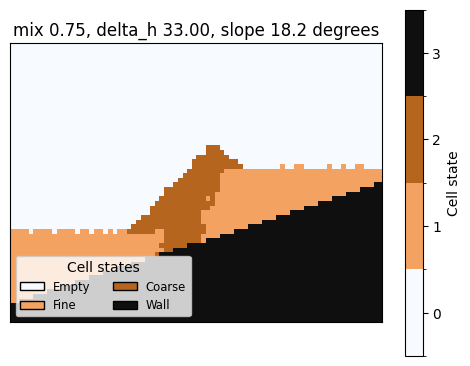

Calibration run complete; delta_h = 33.00 and the heap plot is above.


In [50]:
engine = run_simulation(
    mix_ratio=0.75,
    floor_profile=FloorProfile.SLOPE,
    steps=900,
    seed=42,
    description="Calibration run",
)

metrics = engine.metrics()
print(
    f"After the calibrated run: mix {metrics.mix_ratio:.2f}, delta_h {metrics.delta_h}, top {metrics.top_height}, bottom {metrics.bottom_height}"
)
plot_grid(engine)
print(f"Calibration run complete; delta_h = {metrics.delta_h:.2f} and the heap plot is above.")


## Task 3: Experiments and metrics

We now explore three scenarios that vary the mix ratio and floor profile: fine-dominant slope, balanced slope, and coarse-dominant stepped floor. Each run emits grains for a long sequence so the heap stabilizes and `delta_h` can be read out.

Settled after 1000 bottom-up steps where the heap still moved (no change afterward).
Reached the iteration limit (1000); the heap might still be adjusting.
Fine-dominant slope parameters: mix_ratio=0.80, floor_profile=slope, steps=800, seed=113, floor_min=4, floor_max=30, coarse_slide=0.05, settle_after=True, floor_angle=18.22
+---------------+-------+
| Parameter     | Value |
+---------------+-------+
| mix_ratio     | 0.80  |
| floor_profile | slope |
| steps         | 800   |
| seed          | 113   |
| floor_min     | 4     |
| floor_max     | 30    |
| coarse_slide  | 0.05  |
| settle_after  | True  |
| floor_angle   | 18.22 |
+---------------+-------+
Settled after 1000 bottom-up steps where the heap still moved (no change afterward).
Reached the iteration limit (1000); the heap might still be adjusting.
Balanced slope parameters: mix_ratio=0.50, floor_profile=slope, steps=1200, seed=214, floor_min=4, floor_max=30, coarse_slide=0.05, settle_after=True, floor_angle=18.22
+-------

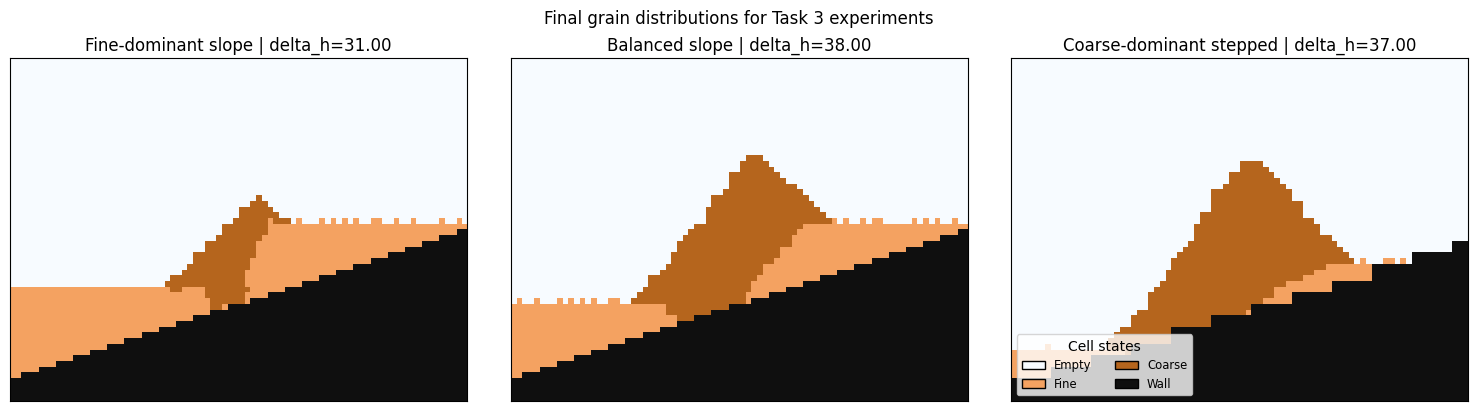

Task 3 experiments complete; refer to the printed table and subplot grid above for delta_h insights.


In [51]:
experiment_specs = [
    ("Fine-dominant slope", 0.8, FloorProfile.SLOPE, 800, 113),
    ("Balanced slope", 0.5, FloorProfile.SLOPE, 1200, 214),
    ("Coarse-dominant stepped", 0.2, FloorProfile.STEPPED, 1400, 317),
]

records = []
engines = []
for label, mix, profile, steps, seed in experiment_specs:
    engine = run_simulation(
        mix_ratio=mix,
        floor_profile=profile,
        steps=steps,
        seed=seed,
        description=label,
    )
    metrics = engine.metrics()
    records.append((label, mix, profile.value, steps, metrics.delta_h, metrics.top_height, metrics.bottom_height))
    engines.append((label, engine))

row_fmt = "{:<28} | {:>5} | {:>8} | {:>6} | {:>7} | {:>7} | {:>7}"
headers = ["Experiment", "Mix", "Floor", "Steps", "delta_h", "Top", "Bottom"]
header_line = row_fmt.format(*headers)
print(header_line)
print("-" * len(header_line))
for label, mix, floor, steps, delta_h, top, bottom in records:
    print(
        row_fmt.format(
            label,
            f"{mix:.2f}",
            floor,
            steps,
            f"{delta_h:.2f}",
            f"{top:.2f}",
            f"{bottom:.2f}",
        )
    )

fig, axes = plt.subplots(1, len(engines), figsize=(15, 4), constrained_layout=True)
for ax, (label, engine) in zip(axes, engines):
    add_legend = ax is axes[-1]
    plot_grid(engine, ax=ax, colorbar=False, legend=add_legend)
    ax.set_title(f"{label} | delta_h={engine.metrics().delta_h:.2f}")
fig.suptitle("Final grain distributions for Task 3 experiments")
plt.show()
print("Task 3 experiments complete; refer to the printed table and subplot grid above for delta_h insights.")


## Optional: Live animation

Run the cell below to watch the CA evolve step by step. This helps visualize the grain dynamics beyond the static snapshots.

Live animation parameters: mix_ratio=0.65, floor_profile=slope, steps=220, seed=7, interval=150, floor_min=4, floor_max=30, coarse_slide=0.05, floor_angle=18.22
+---------------+-------+
| Parameter     | Value |
+---------------+-------+
| mix_ratio     | 0.65  |
| floor_profile | slope |
| steps         | 220   |
| seed          | 7     |
| interval      | 150   |
| floor_min     | 4     |
| floor_max     | 30    |
| coarse_slide  | 0.05  |
| floor_angle   | 18.22 |
+---------------+-------+


Rendered the live animation for mix 0.65 on a slope floor.


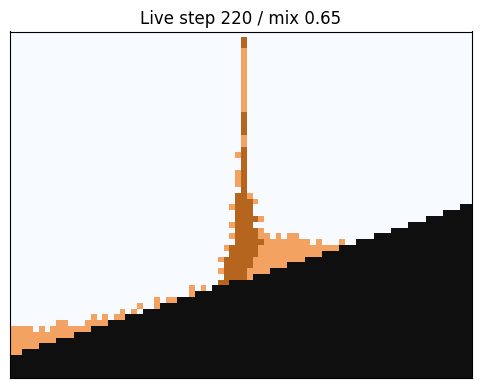

In [52]:
anim_html = animate_simulation(
    mix_ratio=0.65,
    floor_profile=FloorProfile.SLOPE,
    steps=220,
    seed=7,
    description="Live animation",
)

display(anim_html)
print("Rendered the live animation for mix 0.65 on a slope floor.")


## Task 4: Protocol & documentation

To reproduce the notebook results:
1. pip install -r requirements.txt
2. Start the notebook with `jupyter notebook fallingsand.ipynb` or `jupyter lab fallingsand.ipynb`
3. Execute the helper cell to load the simulation helpers
4. Run the calibration cell to confirm `delta_h` and inspect the heap
5. Run the experiment cell to collect multiple `delta_h` values and compare the plots
6. Run the animation cell if you need a live CA view

Division of labour:
- Haller Maximilian gathered the CA terminology and defined the rules.
- Max Schimpf implemented the CA kernel directly within this notebook.
- Kilian Kack contributed the visualization helpers and animation glue.
- Jonas Hackner ran the experiments, documented the metrics, and wrote the protocol described here.